In [29]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, average_precision_score


In [30]:
train_data = pd.read_csv(
    os.path.join(
        os.path.dirname(os.getcwd()),
        'data',
        'training',
        'final_anomaly_training.csv'
    )
)
train_data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,5.000000e+05,5.000000e+05,5.000000e+05,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,7.620937e-01,1.327140e+00,5.115073e-01,-0.118658,0.350732,0.100730,-0.349274,0.087404
std,2.952638e+00,9.519952e+00,1.749233e+00,0.323386,0.477200,0.300971,0.476741,0.282426
min,-4.522426e-01,-3.267150e-01,-6.123311e-01,-1.000000,0.000000,0.000000,-1.000000,0.000000
25%,-2.770901e-01,-2.293651e-01,-3.214841e-01,0.000000,0.000000,0.000000,-1.000000,0.000000
50%,4.034820e-17,-1.820020e-17,3.426058e-17,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.229099e-01,7.706349e-01,6.785159e-01,0.000000,1.000000,0.000000,0.000000,0.000000
max,2.629377e+02,3.885243e+03,1.646674e+02,0.000000,1.000000,1.000000,0.000000,1.000000


In [31]:
fraud_count = train_data[train_data['fraud'] == 1].shape[0]
print(f"Total number of transactions: {train_data.shape[0]}")
print(f"Number of fraud cases: {fraud_count}")

Total number of transactions: 500000
Number of fraud cases: 43702


In [32]:
# Prepare data for anomaly detection (unsupervised)
X = train_data.drop(columns=['fraud'])

model = IsolationForest(contamination=0.01, random_state=42)
model.fit(X)
scores = model.decision_function(X)
anomalies = model.predict(X)

print("Anomaly scores:", scores)
print("Anomalies detected:", np.sum(anomalies == -1))

Anomaly scores: [ 0.27383664  0.29810147  0.29025661 ...  0.29881162  0.19377354
 -0.00958613]
Anomalies detected: 5000


In [33]:
test_data = pd.read_csv(
    os.path.join(
        os.path.dirname(os.getcwd()),
        'data',
        'testing',
        'final_full_testing.csv'
    )
)
test_data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.750620,1.321955,0.508450,-0.118270,0.350066,0.100486,-0.349622,0.087402
std,2.988409,7.277099,1.706213,0.322928,0.476991,0.300647,0.476851,0.282424
min,-0.453118,-0.326656,-0.613159,-1.000000,0.000000,0.000000,-1.000000,0.000000
25%,-0.277234,-0.229634,-0.323067,0.000000,0.000000,0.000000,-1.000000,0.000000
50%,-0.001022,0.001356,-0.000259,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.709864,0.776653,0.677381,0.000000,1.000000,0.000000,0.000000,0.000000
max,482.571443,892.868770,103.155886,0.000000,1.000000,1.000000,0.000000,1.000000


In [34]:
# 1. Prepare test data
X_test = test_data.drop(columns=['fraud'])

# 2. Use the trained model to predict anomalies in the test set
test_scores = model.decision_function(X_test)
test_anomalies = model.predict(X_test)

# 3. (Optional) Evaluate against true labels
y_test = test_data['fraud']

# Convert Isolation Forest labels to binary: -1 (anomaly) → 1 (fraud), 1 (normal) → 0
y_pred = (test_anomalies == -1).astype(int)

print("Anomaly Scores:", test_scores)
print("Anomalies Detected in Test Set:", np.sum(y_pred))
print(classification_report(y_test, y_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, test_scores * -1))
print("PR AUC:", average_precision_score(y_test, test_scores * -1))

Anomaly Scores: [0.28438209 0.24164638 0.26492327 ... 0.26033694 0.25320323 0.26353297]
Anomalies Detected in Test Set: 4921
              precision    recall  f1-score   support

         0.0     0.9141    0.9918    0.9514    456299
         1.0     0.2394    0.0270    0.0485     43701

    accuracy                         0.9075    500000
   macro avg     0.5767    0.5094    0.4999    500000
weighted avg     0.8551    0.9075    0.8725    500000

ROC AUC: 0.753255621451414
PR AUC: 0.17904328577084253


In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc

In [36]:
validation_data = pd.read_csv(
    os.path.join(
        os.path.dirname(os.getcwd()),
        'data',
        'testing',
        'final_heldout_testing.csv'
    )
)
validation_data.describe()

new_test_data = pd.read_csv(
    os.path.join(
        os.path.dirname(os.getcwd()),
        'data',
        'testing',
        'final_split_testing.csv'
    )
)
new_test_data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,0.749996,1.321497,0.508218,-0.118504,0.350292,0.100288,-0.349556,0.087400
std,2.931037,7.339187,1.710100,0.323205,0.477062,0.300384,0.476831,0.282421
min,-0.452080,-0.326656,-0.613159,-1.000000,0.000000,0.000000,-1.000000,0.000000
25%,-0.277367,-0.229685,-0.323477,0.000000,0.000000,0.000000,-1.000000,0.000000
50%,-0.001399,0.000538,-0.000515,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.710764,0.772658,0.678479,0.000000,1.000000,0.000000,0.000000,0.000000
max,398.275579,892.868770,89.624772,0.000000,1.000000,1.000000,0.000000,1.000000


In [37]:
X_val = validation_data.drop(columns=['fraud'])
y_val = validation_data['fraud']

val_scores = model.decision_function(X_val)

In [38]:
# Flip score sign because IsolationForest: lower = more anomalous
precision, recall, thresholds = precision_recall_curve(y_val, -val_scores)
pr_auc = auc(recall, precision)

# Pick best threshold (e.g., maximize F1, or tune for high recall)
best_idx = (2 * precision * recall / (precision + recall)).argmax()
best_thresh = thresholds[best_idx]

print(f"Best threshold: {best_thresh:.4f}, PR AUC: {pr_auc:.4f}")

Best threshold: -0.2258, PR AUC: 0.1765


In [39]:
X_test = new_test_data.drop(columns=['fraud'])
y_test = new_test_data['fraud']

test_scores = model.decision_function(X_test)
y_pred_test = (test_scores < -best_thresh).astype(int)  # flip again

print("Anomaly Scores:", test_scores)
print("Anomalies Detected in Test Set:", np.sum(y_pred_test))
print(classification_report(y_test, y_pred_test, digits=4))
print("ROC AUC:", roc_auc_score(y_test, -test_scores))

Anomaly Scores: [0.15968102 0.29257584 0.16751406 ... 0.24319647 0.24181229 0.26306626]
Anomalies Detected in Test Set: 106021
              precision    recall  f1-score   support

         0.0     0.9727    0.6139    0.7527    228150
         1.0     0.1691    0.8203    0.2803     21850

    accuracy                         0.6319    250000
   macro avg     0.5709    0.7171    0.5165    250000
weighted avg     0.9025    0.6319    0.7114    250000

ROC AUC: 0.7547775456850973


In [40]:
import joblib

dirpath = os.path.join(os.path.dirname(os.getcwd()), "results")
filepath = os.path.join(dirpath, "isolated_forest_model.joblib")
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
if os.path.exists(filepath):
    os.remove(filepath)
joblib.dump(model, filepath)

['c:\\Users\\abudi\\OneDrive\\Documents\\Uni Work\\Capstone Project\\fraud-detection-capstone\\results\\isolated_forest_model.joblib']

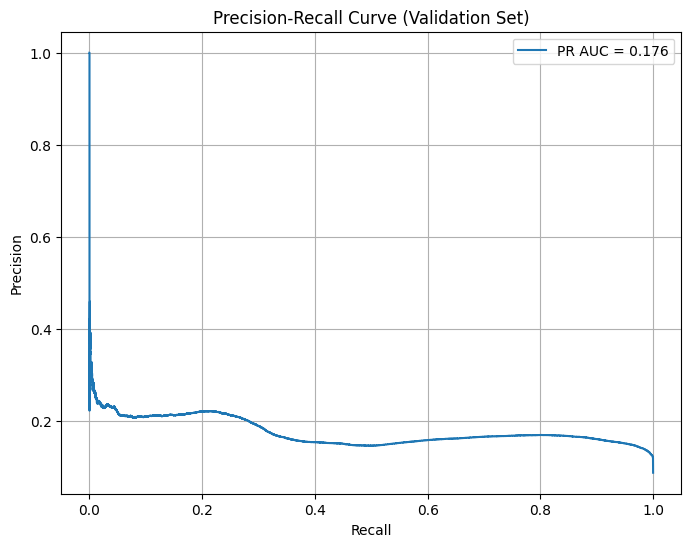

In [41]:
import matplotlib.pyplot as plt

# Plot Precision-Recall curve on validation data as an early metric
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

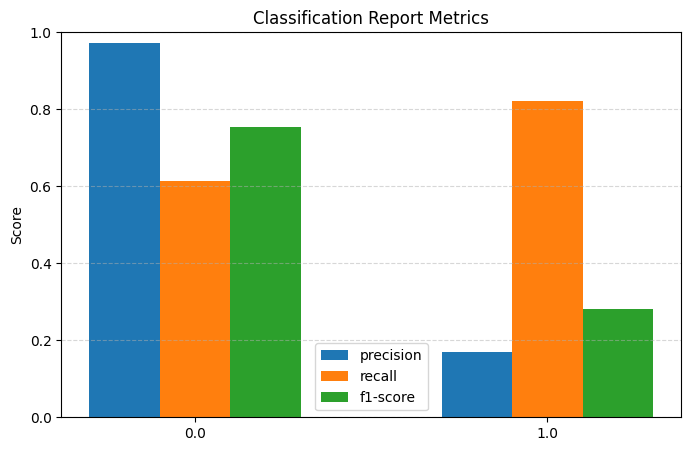

In [45]:
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

# Get classification report as dict
report_dict = classification_report(y_test, y_pred_test, output_dict=True)

# Remove 'accuracy', 'macro avg', 'weighted avg' for class-wise bar plot
classes = [key for key in report_dict.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]
metrics = ['precision', 'recall', 'f1-score']

fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.2
x = np.arange(len(classes))

for i, metric in enumerate(metrics):
    values = [report_dict[cls][metric] for cls in classes]
    ax.bar(x + i * bar_width, values, width=bar_width, label=metric)

ax.set_xticks(x + bar_width)
ax.set_xticklabels(classes)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Classification Report Metrics')
ax.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()